## Using xbatcher for training and inference in deep learning

Keenan Ganz (ganzk [at] uw [dot] edu)

To use deep learning with geoscience data, we have to interconvert between the native format of our data and tensors that the model can operate on. We can summarize this workflow in the below diagram.

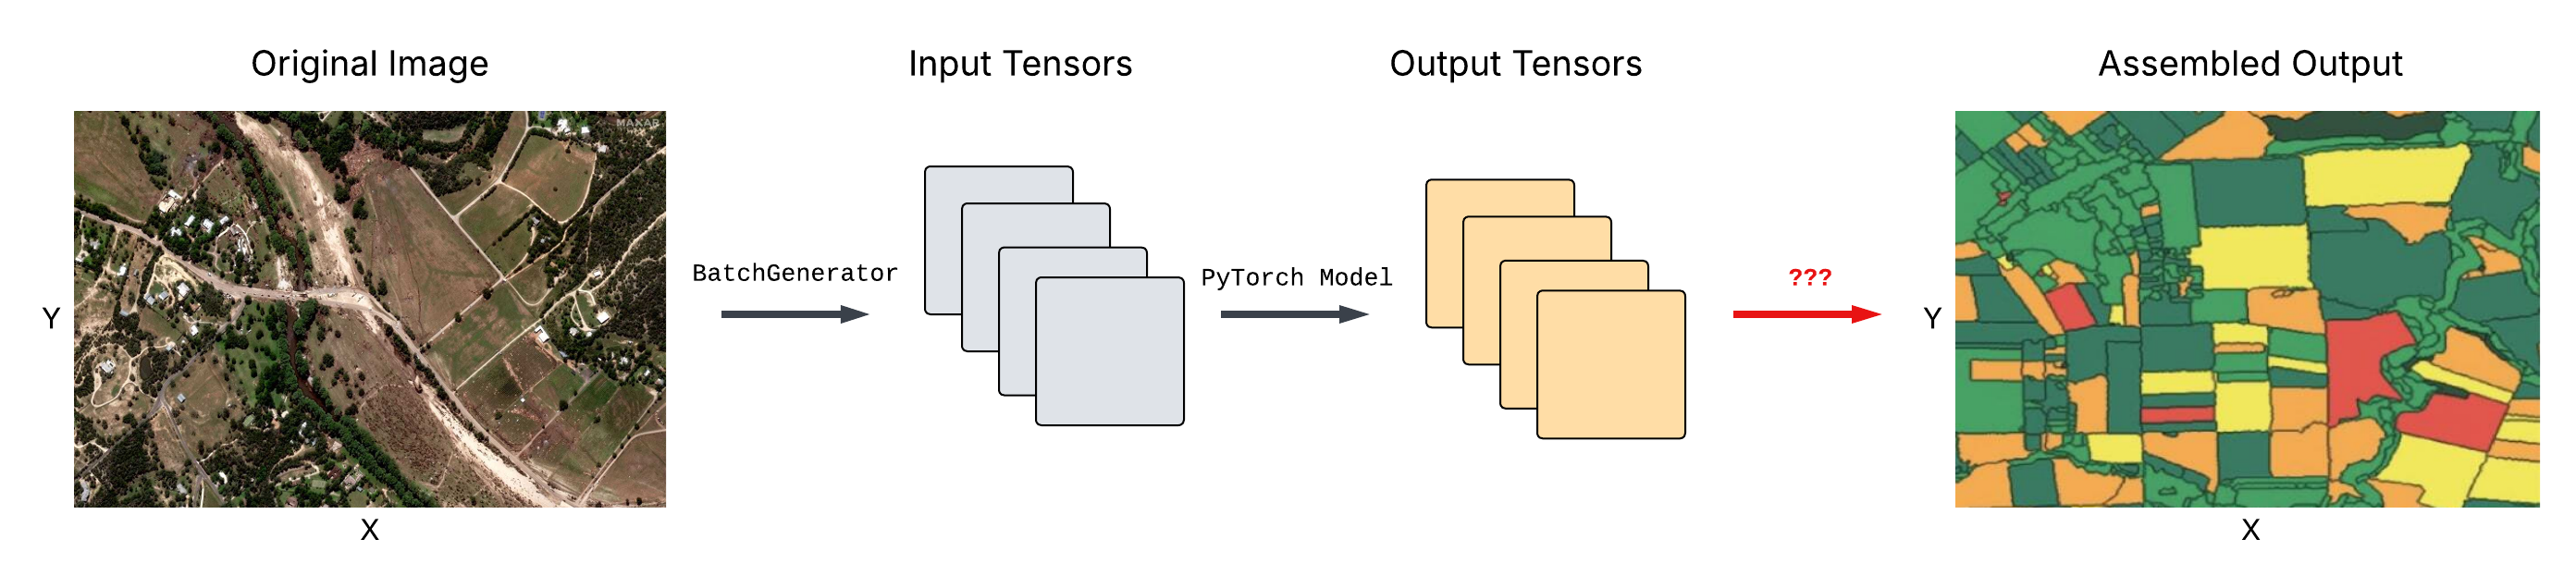

The `xbatcher` library seeks to be a bridge between xarray data structures and deep learning models. We can easily generate small windows of an xarray data structure with the `BatchGenerator` object. However, once we have a trained model, we might also want to assemble the output into a map for a paper, stakeholder, etc. This step is more difficult, but can be made easier by leveraging the indexing information in the `BatchGenerator` object. This notebook demonstrates one approach to this workflow by training an autoencoder on topography data.

## Setup

In [1]:
# Only run this cell if you are on colab and need the autoencoder.py file
# !git clone https://github.com/s-kganz/terrain_autoencoder.git

In [2]:
!pip install -q pytorch-lightning rioxarray planetary_computer stackstac folium matplotlib mapclassify
!pip install -q git+https://github.com/s-kganz/xbatcher.git@patch_filter_resample

In [3]:
import os
try:
    import autoencoder
except ImportError:
    os.chdir("terrain_autoencoder")
    import autoencoder

# DL stuff
import matplotlib
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

# Geospatial stuff
import shapely
import pandas as pd
import geopandas as gpd
import pystac_client
import stackstac
import planetary_computer
import xarray as xr
import xbatcher
import rioxarray
import numpy as np

## Get data

We will start by pulling a segment of NASADEM for Washington's Olympic peninsula.

In [4]:
# Define extent
box = gpd.GeoSeries(shapely.geometry.box(-124.461365,47.221434,-122.986450,48.123934), crs=4326)

In [5]:
# Query for granules
stac = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

items = stac.search(
    bbox=box.total_bounds,
    collections=["nasadem"],
).item_collection()

print(f"Found {len(items)} items")

Found 6 items


In [6]:
# Where are they?
footprints = gpd.GeoSeries(map(lambda x: shapely.geometry.shape(x.geometry), items), crs=4326)
footprints = gpd.GeoDataFrame(data={"idx": list(range(len(footprints)))}, geometry=footprints)

m = box.explore()
m = footprints.explore(m=m, color="red", attr="idx")

m

In [7]:
# This one looks good
items[4]

<Item id=NASADEM_HGT_n47w124>

In [8]:
# One tile is pretty small so we can happily bring it into memory
dem = stackstac.stack(
    [items[4]],
    assets=["elevation"],
    epsg=4326
).squeeze(drop=True).compute()
# Rescale to 0-1
dem = (dem - dem.min()) / (dem.max() - dem.min())
dem

<xarray.DataArray 'stackstac-406509011155cbff4f6040aa07fe512b' (y: 3602, x: 3602)> Size: 104MB
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan, 0.23248007, 0.2370961 , ..., 0.11456148, 0.11624003,
        0.11833823],
       [       nan, 0.23373898, 0.23961393, ..., 0.11749895, 0.12043642,
        0.12253462],
       ...,
       [       nan, 0.00671423, 0.00713386, ..., 0.0365086 , 0.03608896,
        0.03524969],
       [       nan, 0.00671423, 0.00713386, ..., 0.03734788, 0.03734788,
        0.03692824],
       [       nan, 0.00713386, 0.0075535 , ..., 0.03776752, 0.0386068 ,
        0.03776752]], shape=(3602, 3602))
Coordinates:
  * x               (x) float64 29kB -124.0 -124.0 -124.0 ... -123.0 -123.0
  * y               (y) float64 29kB 48.0 48.0 48.0 48.0 ... 47.0 47.0 47.0 47.0
    proj:code       <U9 36B 'EPSG:4326'
    proj:bbox       object 8B {48.00013888888889, 46.999861111111116, -124.00...
    proj:transform  object 8B {0.0, 1.0, -124.00013888888888, -0.000277777777...
    proj:shape      object 8B {3601}
    title           <U9 36B 'Elevation'
    epsg            int64 8B 4326

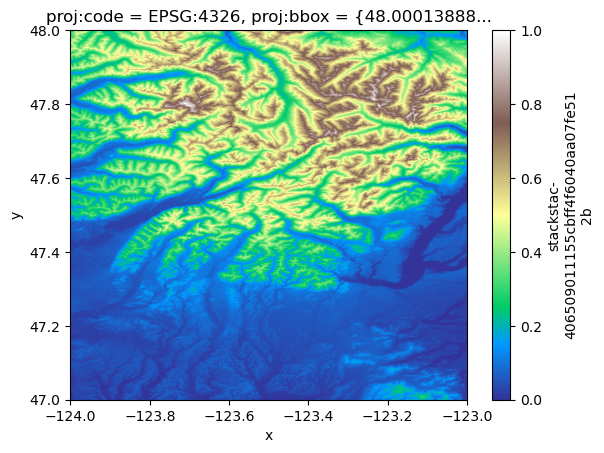

In [9]:
dem.plot.imshow(vmin=0, cmap="terrain")

## Make dataloader

Here we use xbatcher to slice the terrain into patches of 32x32 pixels.

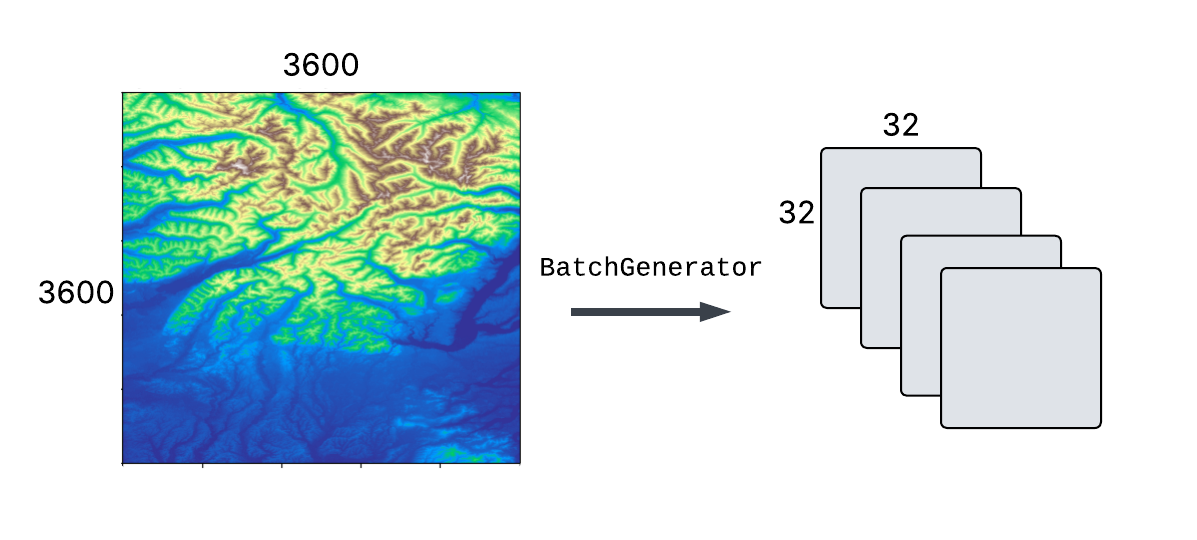

A new feature in `xbatcher` is filtering patches. As a demonstration, suppose we want to discard patches in lowlands. We can do so by only retaining patches with mean greater than 0.25.

In [10]:
# Filter functions take the original xarray object and a dict of
# slice objects that select cells in this patch.
def patch_filter(ds, selector):
    return ds.isel(**selector).values.mean() > 0.25

patch_size_x = 32
patch_size_y = 32

bgen = xbatcher.BatchGenerator(
    dem,
    input_dims=dict(x=patch_size_x, y=patch_size_y),
    input_overlap=dict(x=8, y=8),
    filter_fn=patch_filter
)

print("Number of patches after filtering:", len(bgen))
print("Patch shape:", bgen[0].shape)

Number of patches after filtering: 9824
Patch shape: (32, 32)


To visualize what the filtering does, we will make a binary raster with the same shape as the DEM. Each window that the `BatchGenerator` accepted gets a 1, and all other cells get a zero. We can see from the right panel below that low-elevation areas were excluded. This means that the model will not see terrain data from these regions.

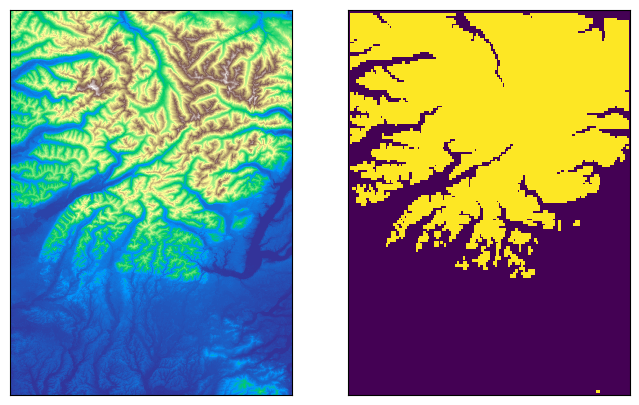

In [11]:
# Visualize where the patches are
arr = xr.DataArray(
    data=np.zeros(dem.shape),
    dims=dem.sizes.keys(),
)

for i, batch in enumerate(bgen):
    indexer = bgen._batch_selectors.selectors[i][0]
    arr.loc[indexer] = 1

arr = arr.assign_coords(dem.coords)

fig, (left, right) = plt.subplots(1, 2, figsize=(8, 5))
dem.plot.imshow(vmin=0, cmap="terrain", ax=left, add_labels=False, add_colorbar=False, xticks=[], yticks=[])
left.set_title("")
arr.plot.imshow(ax=right, add_labels=False, add_colorbar=False, xticks=[], yticks=[])

## `BatchGenerator` -> `DataLoader`

Usually we have to make a few modifications to patches before they go into the model. The `MapDataset` object lets us pass a transformation function that implements these last-minute modifications.

In [12]:
# Convert the batch generator to a torch dataloader.
from xbatcher.loaders.torch import MapDataset

def patch_to_tensor(patch):
    patch = torch.tensor(patch.data)
    patch = torch.nan_to_num(patch)
    patch = torch.unsqueeze(patch, 0)
    patch = patch.float()
    return patch

ds = MapDataset(bgen, transform=patch_to_tensor)
loader = torch.utils.data.DataLoader(ds, batch_size=16, shuffle=True)
print(next(iter(loader)).shape)

torch.Size([16, 1, 32, 32])


It's worth focusing on the shape of this batch. In my experience, 90% of neural network problems come from tensors having the incorrect shape! Let's unpack what each dimension means here.

 - Dim 1: Batch dimension. This is the number of windows from the DEM that the model will see at each training step. This size is 16 because we set `batch_size=16` in the `DataLoader`.
 - Dim 2: Channel dimension. The autoencoder architecture we use below assumes that input data has a channel axis. For compatibility we add a singleton channel dimension to the topography data.
 - Dim 3/4: Spatial dimensions. These correspond to the `y` and `x` dimensions of the original DEM. Since we specified patches of size 32 in the `BatchGenerator`, this is as we expect.

We also need a validation set to monitor overfitting. A natural choice is just an adjacent granule. The function below encapsulates much of the above code so we can make data loaders for an arbitrary DEM tile.

In [13]:
%%time
def item_to_dataloader(stac_item, **loader_args):
    arr = stackstac.stack(
        [stac_item],
        assets=["elevation"],
        epsg=4326
    ).squeeze(drop=True).compute()

    # Rescale from 0-1
    arr = (arr - arr.min()) / (arr.max() - arr.min())

    bgen = xbatcher.BatchGenerator(arr, input_dims=dict(x=patch_size_x, y=patch_size_y), input_overlap=dict(x=8, y=8), filter_fn=patch_filter)
    ds = MapDataset(bgen, transform=patch_to_tensor)
    loader = torch.utils.data.DataLoader(ds, **loader_args)

    return loader

train_loader = item_to_dataloader(items[4], batch_size=16, shuffle=True)
print("Batches in training:", len(train_loader))
val_loader   = item_to_dataloader(items[0], batch_size=16, shuffle=False)
print("Batches in validation:", len(val_loader))

Batches in training: 614
Batches in validation: 415
CPU times: user 6.09 s, sys: 178 ms, total: 6.27 s
Wall time: 7.39 s


### Define model
This implementation of deep autoencoders comes from [this tutorial](https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/08-deep-autoencoders.html#Setup). Autoencoders are a model architecture that consists of an encoder and decoder. The encoder compresses the input to a compact representation of the original (known as a *latent space*), while the decoder arm reconstructs the original input from the latent space. Or, as a diagram:

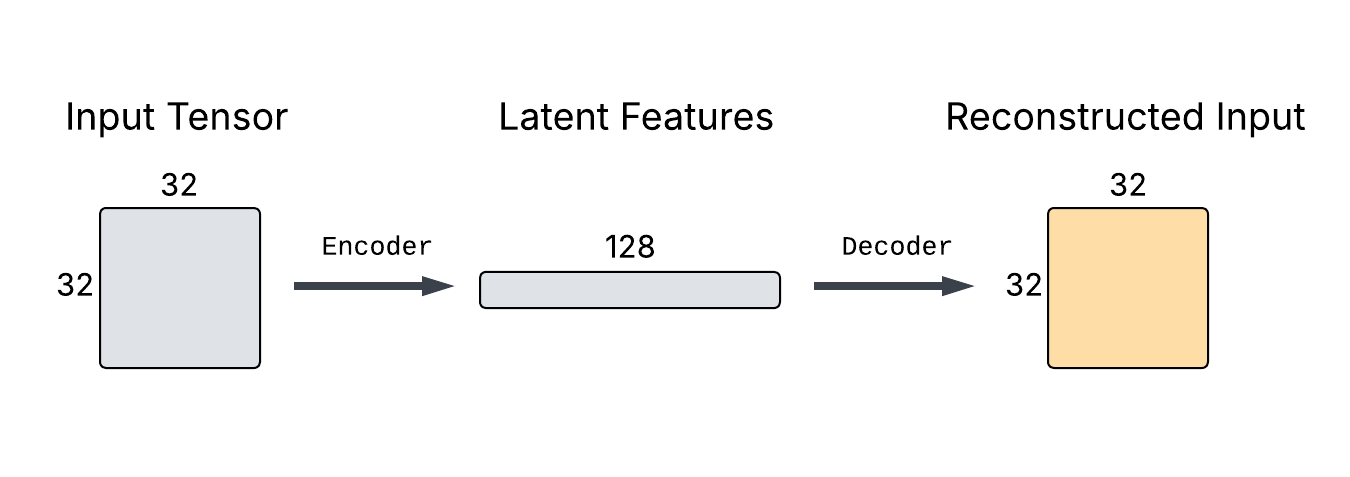

You don't have to worry about the details of how autoencoder are implemented for this tutorial, but if you are, check out the file autoencoder.py.

In [14]:
import autoencoder
from importlib import reload
reload(autoencoder)

<module 'autoencoder' from '/home/jovyan/terrain/autoencoder.py'>

Since the autoencoder is reconstructing its input, the output shape should exactly match the input shape. I like to have an assert statement before starting training.

In [15]:
a_batch = next(iter(train_loader))
enc = autoencoder.Autoencoder(num_input_channels=1, base_channel_size=32, latent_dim=128)
assert(enc(a_batch).shape == a_batch.shape) # check that output shape matches input

## Model training
The below function instantiates and trains a new model. This will create a new directory called `lightning_logs` that contains model checkpoints. You can also manipulate the size of the latent space to see how that affects model performance. Remember that the input patches have 32x32 = 1024 pixels.

In [16]:
def train_autoencoder(latent_dim):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=10,
        limit_val_batches=10
    )
    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    model = autoencoder.Autoencoder(num_input_channels=1, base_channel_size=16, latent_dim=latent_dim, width=patch_size_x, height=patch_size_y)
    trainer.fit(model, train_loader, val_loader)
    result = trainer.test(model, dataloaders=val_loader)
    return trainer, model, result


In [17]:
trainer, model, result = train_autoencoder(128)
# model = Autoencoder.load_from_checkpoint("path/to/checkpoint")

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/srv/conda/envs/notebook/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes       | Out sizes     
------------------------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/srv/conda/envs/notebook/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/srv/conda/envs/notebook/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.1410226821899414     │
└───────────────────────────┴───────────────────────────┘

## View reconstructions

So does the model work? We can check this by seeing how the model reconstructions compare to the input patches.

In [18]:
# Only take the first n samples from the batch
n = 4
batch = next(iter(val_loader))[:n, ...]
model.eval()
out = model(batch)

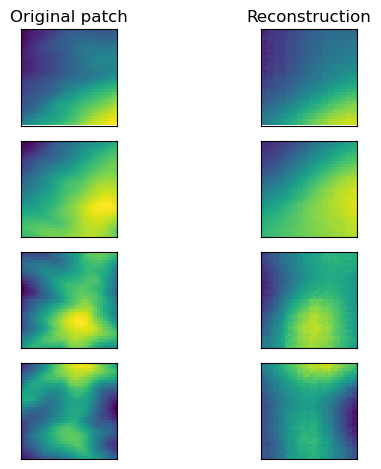

In [19]:
fig, axes = plt.subplots(n, 2)

imshow_args = dict(cmap="viridis")

for i in range(n):
    original = batch[i, ...].squeeze().detach().numpy()
    reconst  = out[i, ...].squeeze().detach().numpy()

    min_, max_ = np.min(original), np.max(original)
    axes[i, 0].imshow(original, vmin=min_, vmax=max_, **imshow_args)
    axes[i, 0].set_yticks([])
    axes[i, 0].set_xticks([])
    axes[i, 1].imshow(reconst, vmin=min_, vmax=max_, **imshow_args)
    axes[i, 1].set_yticks([])
    axes[i, 1].set_xticks([])

axes[0, 0].set_title("Original patch")
axes[0, 1].set_title("Reconstruction")
fig.tight_layout()
plt.show()

Not bad! Remember that the latent space has 128 features. So, despite compressing the input patches into a space with 1/8 the original information, we can still reasonably reconstruct the input.

## Assemble model output into a new data array

Now suppose we want to transform our network output into a data array that we can visualize. We need to run each patch through the network and reassmble them while accounting for overlaps. If we were to do this manually, you might imagine a complicated for loop structure like so.

In [20]:
output_array = np.zeros(dem.shape)
output_n     = np.zeros(dem.shape)

for x_start in range(0, dem.shape[0]-patch_size_x, patch_size_x):
    for y_start in range(0, dem.shape[1]-patch_size_y, patch_size_y):
        inp = torch.tensor(dem.data[y_start:y_start+patch_size_y, x_start:x_start+patch_size_x])
        inp = torch.nan_to_num(inp).unsqueeze(0).unsqueeze(0).float()
        out = model(inp).detach().numpy()

        output_array[y_start:y_start+patch_size_y, x_start:x_start+patch_size_x] += out[0, 0, ...]
        output_n[y_start:y_start+patch_size_y, x_start:x_start+patch_size_x] += 1

/tmp/ipykernel_2787/1825508455.py:2: RuntimeWarning: invalid value encountered in divide
  output_avg = output_array / output_n


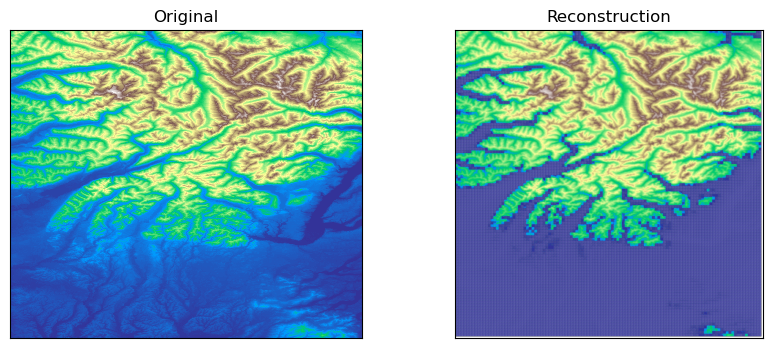

In [21]:
# Simple average in pixels where windows overlap
output_avg = output_array / output_n

fig, (left, right) = plt.subplots(1, 2, figsize=(10, 4))

right.imshow(output_avg, vmin=0, vmax=1, cmap="terrain")
right.set_xticks([])
right.set_yticks([])
right.set_title("Reconstruction")

dem.plot(ax=left, cmap="terrain", add_labels=False, add_colorbar=False, xticks=[], yticks=[], vmin=0, vmax=1)
left.set_title("Original")

plt.show()

You can see how omitting lowlands from the training set makes the model perform very poorly there.

The above loops are verbose, error prone, and difficult to modify for other use cases. What if the output tensor has a new dimension, or no longer has a dimension in the original array? We can simplify this task by utilizing the windowing information already contained in the batch generator. To do so we need a few hints about the output tensors the model will generate. Each output tensor dimension, except for the batch dimension, must satisfy one of the following conditions.

 - Be a new dimension not in the original data array
 - Have size equal to the window used by the batch generator
 - Have size equal to 1, in which case the tensor is broadcast along that window dimension.

Suppose we want to access the 128-dimensional latent vector in the encoder step of the above autoencoder. If we pass a single patch into the encoder, what output shape do we get?

In [22]:
my_patch = train_loader.dataset[0].unsqueeze(0)
print("Input patch:", my_patch.shape)
out = model.encoder(my_patch)
print("Encoded tensor:", out.shape)

Input patch: torch.Size([1, 1, 32, 32])
Encoded tensor: torch.Size([1, 128])


The resulting shape is (1, 128). We ignore the first (batch) dimension, and the second dimension is not in the original data array. So, we should be able to combine output tensors easily. We will only do this demo on a portion of the overall DEM since a float array of shape (3600, 3600, 128) takes up 13 GB.

In [23]:
from tqdm.autonotebook import tqdm

def assemble_model_output(dataset: MapDataset, model: torch.nn.Module, tensor_shape: dict[str, str]):
    '''
    Feed examples from a xbatcher MapDataset to a PyTorch model and assemble
    the output as a DataArray.

    Parameters
    ----------
    dataset : ``xbatcher.loaders.torch.MapDataset``
      The MapDataset encapsulating the underlying xarray object and
      BatchGenerator that generate samples. The ``y_generator`` property is
      unused.
    model : ``torch.nn.Module``
      The torch model that will receive examples from the MapDataset.
    tensor_shape : ``dict``
      Dictionary specifying the dimensions and size of output tensors from
      ``model``. This defines the shape of the output array (see notes).

    Returns
    -------
    output_da: xr.DataArray
      Model output reassembled to have the same dimensions and coordinates
      as the input array, where applicable. If a cell is in mulitple windows,
      model output is averaged. The array's dimensions are the union of the
      tensor's dimensions and those defined in the ``input_dims`` parameter
      in the BatchGenerator. New dimensions have the same size as output
      tensors, while existing dimensions have the same size as the original
      xarray object (see Notes)

    Notes
    -----
    Models can generate tensors with dimensions that are not in the original
    xarray object, such as a class dimension for a classification problem. New
    dimensions can be of arbitrary size. Tensor dimensions that are part of
    the original xarray object (e.g. x, y coordinates) must either have the same
    size as given in the ``input_dims`` parameter in the underlying
    BatchGenerator, or have size 1. In the latter case, this axis is broadcast
    against the slice defined by the batch generator.

    Suppose we have the following array shapes and dimensions:
      Original xarray object: (100, 100, 10), ("x", "y", "time")
      Batches: (5, 5), ("x", "y")
      Output tensor: (5, 5, 3), ("x", "y", "class")

    We know that the output array's dimensions will be the union of the batch
    dimensions and the tensor dimensions, which is ``("x", "y", "class")``.
    The first two dimensions, x and y, are both in the original xarray object,
    so the output array will have the same size in those dimensions. The final
    dimension, class, is not in the original xarray object, so the output array
    will match the tensor size in that dimension. Therefore, the output array
    will have dimensions ("x", "y", "class") and shape (100, 100, 3).

    '''
    bgen = dataset.X_generator
    output_da_dims = list(tensor_shape.keys())
    for input_dim in bgen.input_dims.keys():
        if input_dim not in output_da_dims: output_da_dims.append(input_dim)

    output_da_size = tuple(
        bgen.ds.sizes[d] if d in bgen.input_dims else tensor_shape[d]
        for d in output_da_dims
    )

    n_new_axes = len(output_da_size) - len(tensor_shape)
    new_ax_tuple = tuple(i+len(tensor_shape) for i in range(n_new_axes))

    output_da_coords = xr.Coordinates({
        dim:bgen.ds.indexes[dim] for dim in output_da_dims if dim in bgen.ds.indexes
    })

    output_da = xr.DataArray(
        data=np.zeros(output_da_size),
        dims=output_da_dims,
    )
    output_n = xr.full_like(output_da, fill_value=0)

    for i, batch in tqdm(enumerate(mds), total=len(mds)):
        indexer = bgen._batch_selectors.selectors[i][0]
        model_output = model(batch.unsqueeze(0)).detach().numpy()[0, ...]
        # Pad if necessary - this doesn't error if the tuple is empty
        model_output = np.expand_dims(model_output, axis=new_ax_tuple)
        output_da.loc[indexer] += model_output
        output_n.loc[indexer] += 1

    # Compute average - ignoring division by zero
    with np.errstate(divide='ignore'):
        output_da = output_da / output_n
    output_da = output_da.where(output_n > 0)

    # Assign coords
    output_da = output_da.assign_coords(output_da_coords)

    return output_da


In [24]:
dem_clip = dem.isel(x=slice(1500, 2000), y=slice(1500, 2000))

bgen = xbatcher.BatchGenerator(
    dem_clip,
    input_dims=dict(x=patch_size_x, y=patch_size_y),
    input_overlap=dict(x=8, y=8)
)

mds = MapDataset(bgen, transform=patch_to_tensor)

In [25]:
output_ch = assemble_model_output(mds, model.encoder, dict(channel=128))
output_ch

  0%|          | 0/400 [00:00<?, ?it/s]

<xarray.DataArray (channel: 128, x: 500, y: 500)> Size: 256MB
array([[[ 0.19022043,  0.19022043,  0.19022043, ...,         nan,
                 nan,         nan],
        [ 0.19022043,  0.19022043,  0.19022043, ...,         nan,
                 nan,         nan],
        [ 0.19022043,  0.19022043,  0.19022043, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 0.4646073 ,  0.4646073 ,  0.4646073 , ...,         nan,
                 nan,         nan],
        [ 0.4646073 ,  0.4646073 ,  0.4646073 , ...,         nan,
                 nan,         nan],
        [ 0.4646073 ,  0.4646073 ,  0.4646073 , ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 0.93287879,  0.93287879,  0.93287879, ...,         nan,
                 nan,         nan],
        [ 0.93287879,  0.93287879,  0.93287879, ...,         nan,
                 nan,         nan],
        [ 0.93287879,  0.93287879,  0.93287879, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], shape=(128, 500, 500))
Coordinates:
  * x        (x) float64 4kB -123.6 -123.6 -123.6 ... -123.4 -123.4 -123.4
  * y        (y) float64 4kB 47.58 47.58 47.58 47.58 ... 47.45 47.45 47.45 47.45
Dimensions without coordinates: channel

Notably, this approach retains the coordinate information from the original data array. This makes it easy to use model otuput in downstream applications.

Now what if we wanted to put all the reconstructions back together into their own data array. Like before, we start by considering the shape of the output tensors.

In [26]:
out = model(my_patch)
print(out.shape)

torch.Size([1, 1, 32, 32])


We ignore the leading batch dimension, and remind ourselves that the remaining dimensions correspond to the channel axis, the y axis, and the x axis. Using our rules above is this tensor shape valid?

 - Channel axis: this axis is not in the original data array, so it is OK.
 - X/Y axes: these axes are in the original data array, and the output shape matches the window size we defined in the `BatchGenerator`. So, these dimensions are also OK.

In [27]:
output_assemble = assemble_model_output(mds, model, dict(channel=1, y=32, x=32))
output_assemble

  0%|          | 0/400 [00:00<?, ?it/s]

<xarray.DataArray (channel: 1, y: 500, x: 500)> Size: 2MB
array([[[-0.86548769, -0.82589853, -0.10987122, ...,         nan,
                 nan,         nan],
        [-0.99798107, -0.99182481, -0.99746215, ...,         nan,
                 nan,         nan],
        [-0.71491605, -0.93843448, -0.52186036, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], shape=(1, 500, 500))
Coordinates:
  * y        (y) float64 4kB 47.58 47.58 47.58 47.58 ... 47.45 47.45 47.45 47.45
  * x        (x) float64 4kB -123.6 -123.6 -123.6 ... -123.4 -123.4 -123.4
Dimensions without coordinates: channel

Now we can compare how our reconstructions do on a region of the DEM.

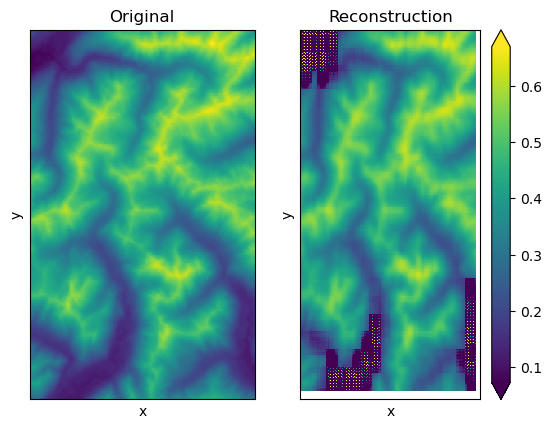

In [28]:
fig, (left, right) = plt.subplots(1, 2)
vmin, vmax = dem_clip.min(), dem_clip.max()

dem_clip.plot(ax=left, add_colorbar=False, xticks=[], yticks=[], vmin=vmin, vmax=vmax)
output_assemble.plot(ax=right, xticks=[], yticks=[], vmin=vmin, vmax=vmax)
left.set_title("Original")
right.set_title("Reconstruction")
plt.show()

And make a nice scatterplot of pixel-by-pixel correspondence.

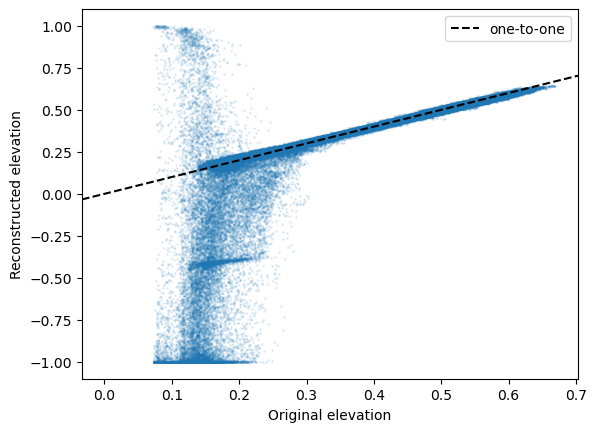

In [29]:
y     = dem_clip.data.flatten()
y_hat = output_assemble.data[0].flatten()

plt.scatter(y, y_hat, s=1, alpha=0.1)
plt.xlabel("Original elevation")
plt.ylabel("Reconstructed elevation")
plt.axline((0, 0), slope=1, linestyle="--", color="black", label="one-to-one")
plt.legend()
plt.show()

Removing lowlands from training definitely had an effect. Model predictions go all over the place once we drop below the 25th percentile of elevation.

The above examples show a much more concise, readable, and modifiable approach to reconstructing neural network output than using for loops. Additional testing is necessary before adding this functionality to `xbatcher`. In the meantime, your feedback and comments would be especially helpful.